# Churn – Abandon Client Télécom

Auteurs: Julien Billeter et Michael Strefeler

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

random.seed(42)

## Prétraitment des données

### Données

In [212]:
data = pd.read_csv('data/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Données manquantes

In [213]:
data.isna().sum()
print("Il n'y a pas de données manquantes dans le dataset.")

Il n'y a pas de données manquantes dans le dataset.


### Equilibre des classes

In [214]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

### Valeurs uniques par attribut

In [215]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"{col}: {data[col].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


### Description des variables

In [216]:
description = pd.read_csv('data/Names.csv', delimiter=';', header=None)
description

,0,1
0,customerID,Customer ID
1,gender,Whether the customer is a male or a female
2,SeniorCitizen,Whether the customer is a senior citizen or no...
3,Partner,Whether the customer has a partner or not (Yes...
4,Dependents,Whether the customer has dependents or not (Ye...
5,Tenure,Number of months the customer has stayed with ...
6,PhoneService,Whether the customer has a phone service or no...
7,MultipleLines,Whether the customer has multiple lines or not...
8,InternetService,"Customer's internet service provider (DSL, Fib..."
9,OnlineSecurity,Whether the customer has online security or no...


### Suppression de variables

In [217]:
data.drop(columns=['customerID'], inplace=True)

In [218]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

yes_no_columns = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'
]

for col in yes_no_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# One-hot encoding for multi-category columns (including 3-way columns like InternetService)
multi_category_columns = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaymentMethod'
]

data = pd.get_dummies(data, columns=multi_category_columns, drop_first=True)

# Final split into features and target
X = data.drop(columns=['Churn'])
y = data['Churn']

In [219]:
X.shape

(7043, 30)

### Mise à l'échelle de certaines variables

In [220]:
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
X = X.dropna()
y = y.loc[X.index]

## Exploration des données

### Matrice de corrélation

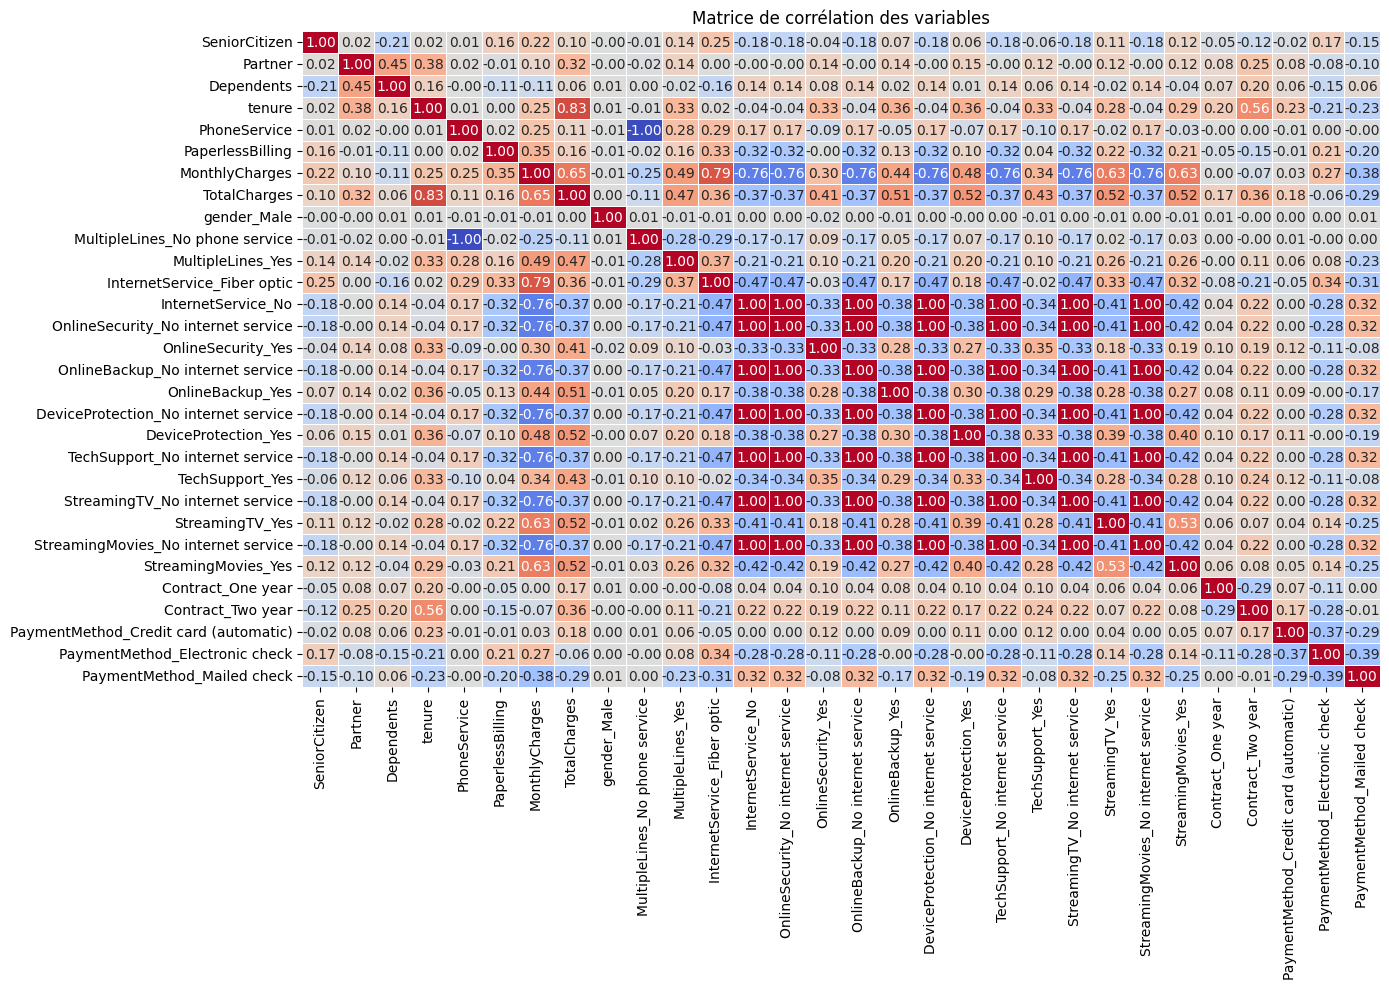

In [221]:
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()

## Sélection des 10 attributs les plus importants (par feature importance)

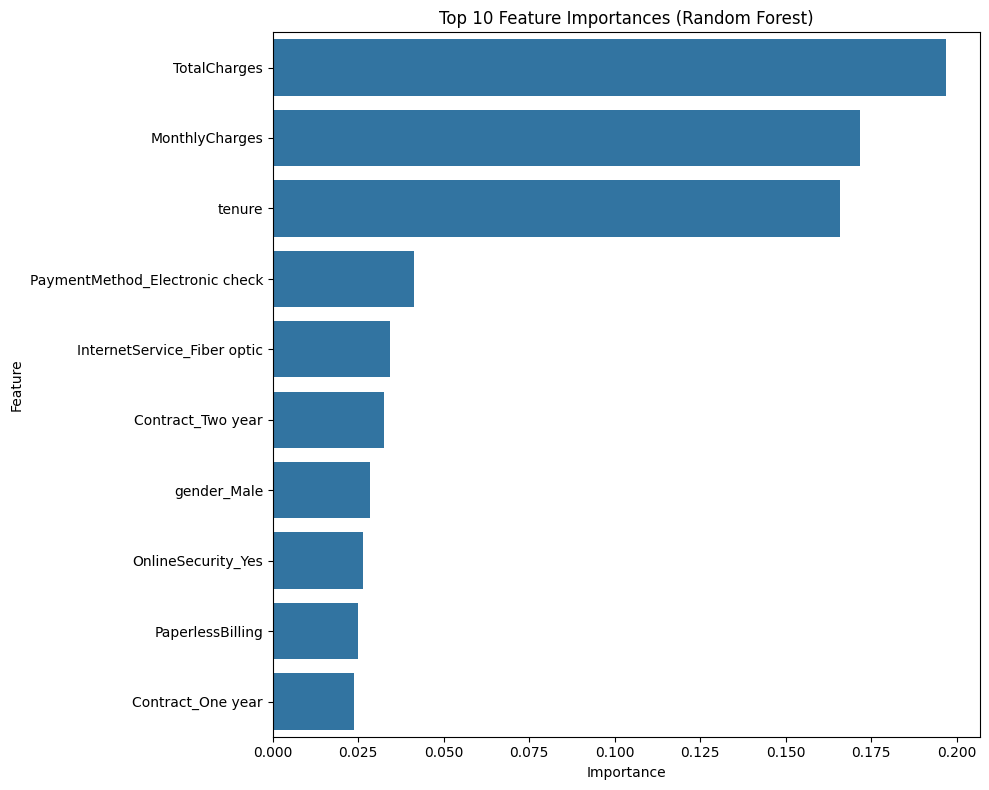

In [222]:
# Entraînement du Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Importance des attributs
importances = rf.feature_importances_
feature_names = X.columns

# Création d'un DataFrame pour la visualisation des importances
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [223]:
top_10_features = feat_imp_df['Feature'].head(10).tolist()
X_top10 = X[top_10_features]

### Séparation train et test

In [224]:
# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42, stratify=y)

## Modèle transparent : explications ante-hoc

In [225]:
def evaluate_model(y_test, y_pred, title):
    # Évaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Précision: {precision_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, target_names=["Stay", "Leave"]))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    etiquettes = ['Stay', 'Leave']
    df_cm = pd.DataFrame(cm, index=etiquettes, columns=etiquettes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matrice de confusion ({title})')
    plt.ylabel('Ground truth')
    plt.xlabel('Predictions')
    plt.tight_layout()
    plt.show()

### Classifieur par arbre de décision (Decison Tree, DT)

Accuracy: 0.78
Précision: 0.61
F1-score: 0.54

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.82      0.89      0.86      1033
       Leave       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



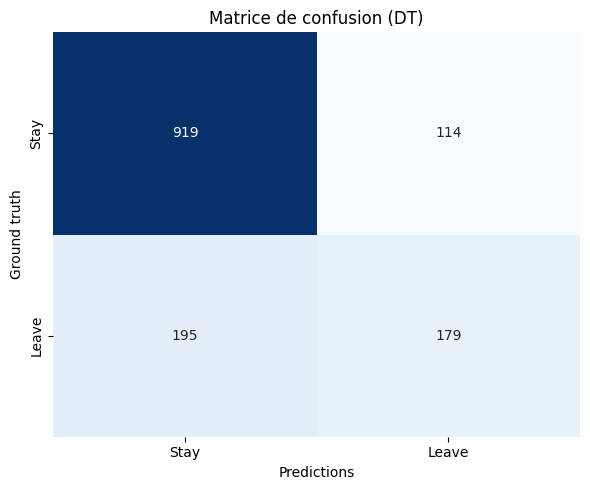

In [226]:
# Entraînement du modèle
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

# Prédictions
y_pred = tree.predict(X_test)

evaluate_model(y_test, y_pred, 'DT')

## Modèle black-box : explications post-hoc

In [ ]:
# Transformation des données pour PyTorch
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Conversion en tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [228]:
g = torch.Generator()
g.manual_seed(42)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=g)

### Modèle

In [229]:
class ChurnNet(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [230]:
model = ChurnNet(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Entraînement du modèle

In [231]:
epochs = 100
loss_epoch = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    loss_epoch.append(average_loss)

    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} — Loss: {average_loss:.4f}")

Epoch 1/100 — Loss: 0.5278
Epoch 21/100 — Loss: 0.4121
Epoch 41/100 — Loss: 0.4060
Epoch 61/100 — Loss: 0.4023
Epoch 81/100 — Loss: 0.3975
Epoch 100/100 — Loss: 0.3952


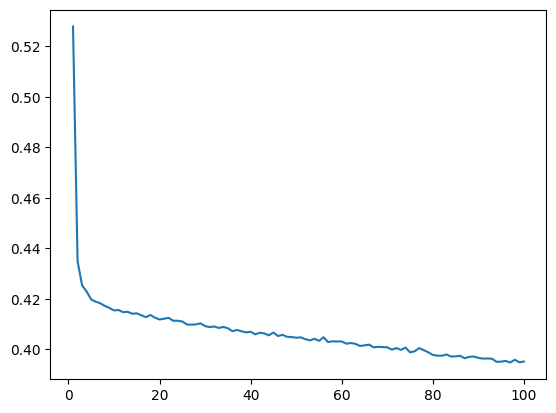

In [241]:
plt.plot(range(1, epochs + 1), loss_epoch)
plt.show()

Accuracy: 0.80
Précision: 0.66
F1-score: 0.58

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.84      0.90      0.87      1033
       Leave       0.66      0.51      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



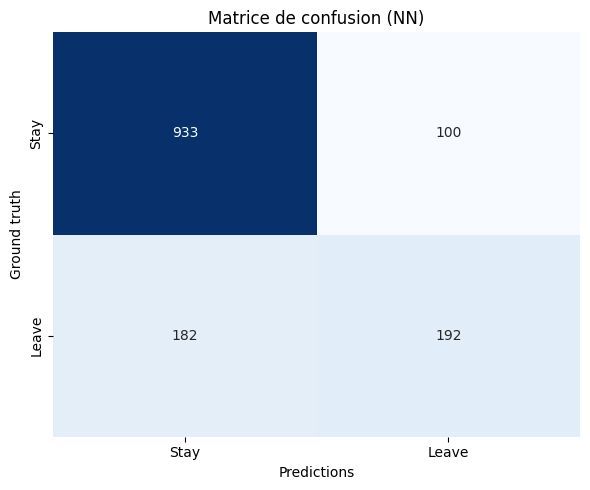

In [233]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_tensor.squeeze().numpy()

evaluate_model(y_true, y_pred, 'NN')

In [234]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_train_tensor).squeeze().numpy()
    y_pred_nn = (y_pred_prob > 0.5).astype(int)

Accuracy: 0.80
Précision: 0.69
F1-score: 0.56

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.83      0.92      0.87      1033
       Leave       0.69      0.47      0.56       374

    accuracy                           0.80      1407
   macro avg       0.76      0.70      0.71      1407
weighted avg       0.79      0.80      0.79      1407



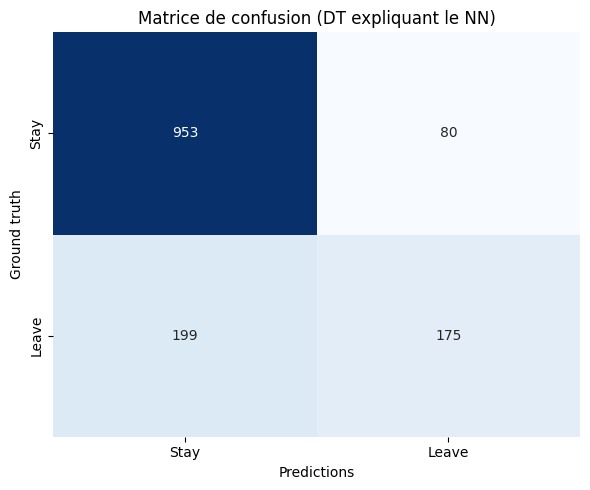

In [242]:
# Entraînement de l'arbre en série
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_pred_nn)

# Prédictions
y_pred_hat = tree.predict(X_test)

evaluate_model(y_test, y_pred_hat, 'DT expliquant le NN')

In [236]:
from sklearn.tree import export_text
rules = export_text(tree, feature_names=X_train.columns.tolist(), class_names=['Stay', 'Leave'])
print(rules)

|--- tenure <= -0.89
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |--- MonthlyCharges <= -0.81
|   |   |   |   |--- MonthlyCharges <= -0.98
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- MonthlyCharges >  -0.98
|   |   |   |   |   |--- class: Stay
|   |   |   |--- MonthlyCharges >  -0.81
|   |   |   |   |--- TotalCharges <= -0.96
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- TotalCharges >  -0.96
|   |   |   |   |   |--- class: Stay
|   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |--- tenure <= -1.22
|   |   |   |   |--- PaperlessBilling <= 0.50
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- PaperlessBilling >  0.50
|   |   |   |   |   |--- class: Leave
|   |   |   |--- tenure >  -1.22
|   |   |   |   |--- TotalCharges <= -0.90
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- TotalCharges >  -0.90
|   |   |   |   |   |--- class: Stay
|   |--- InternetService_Fiber 

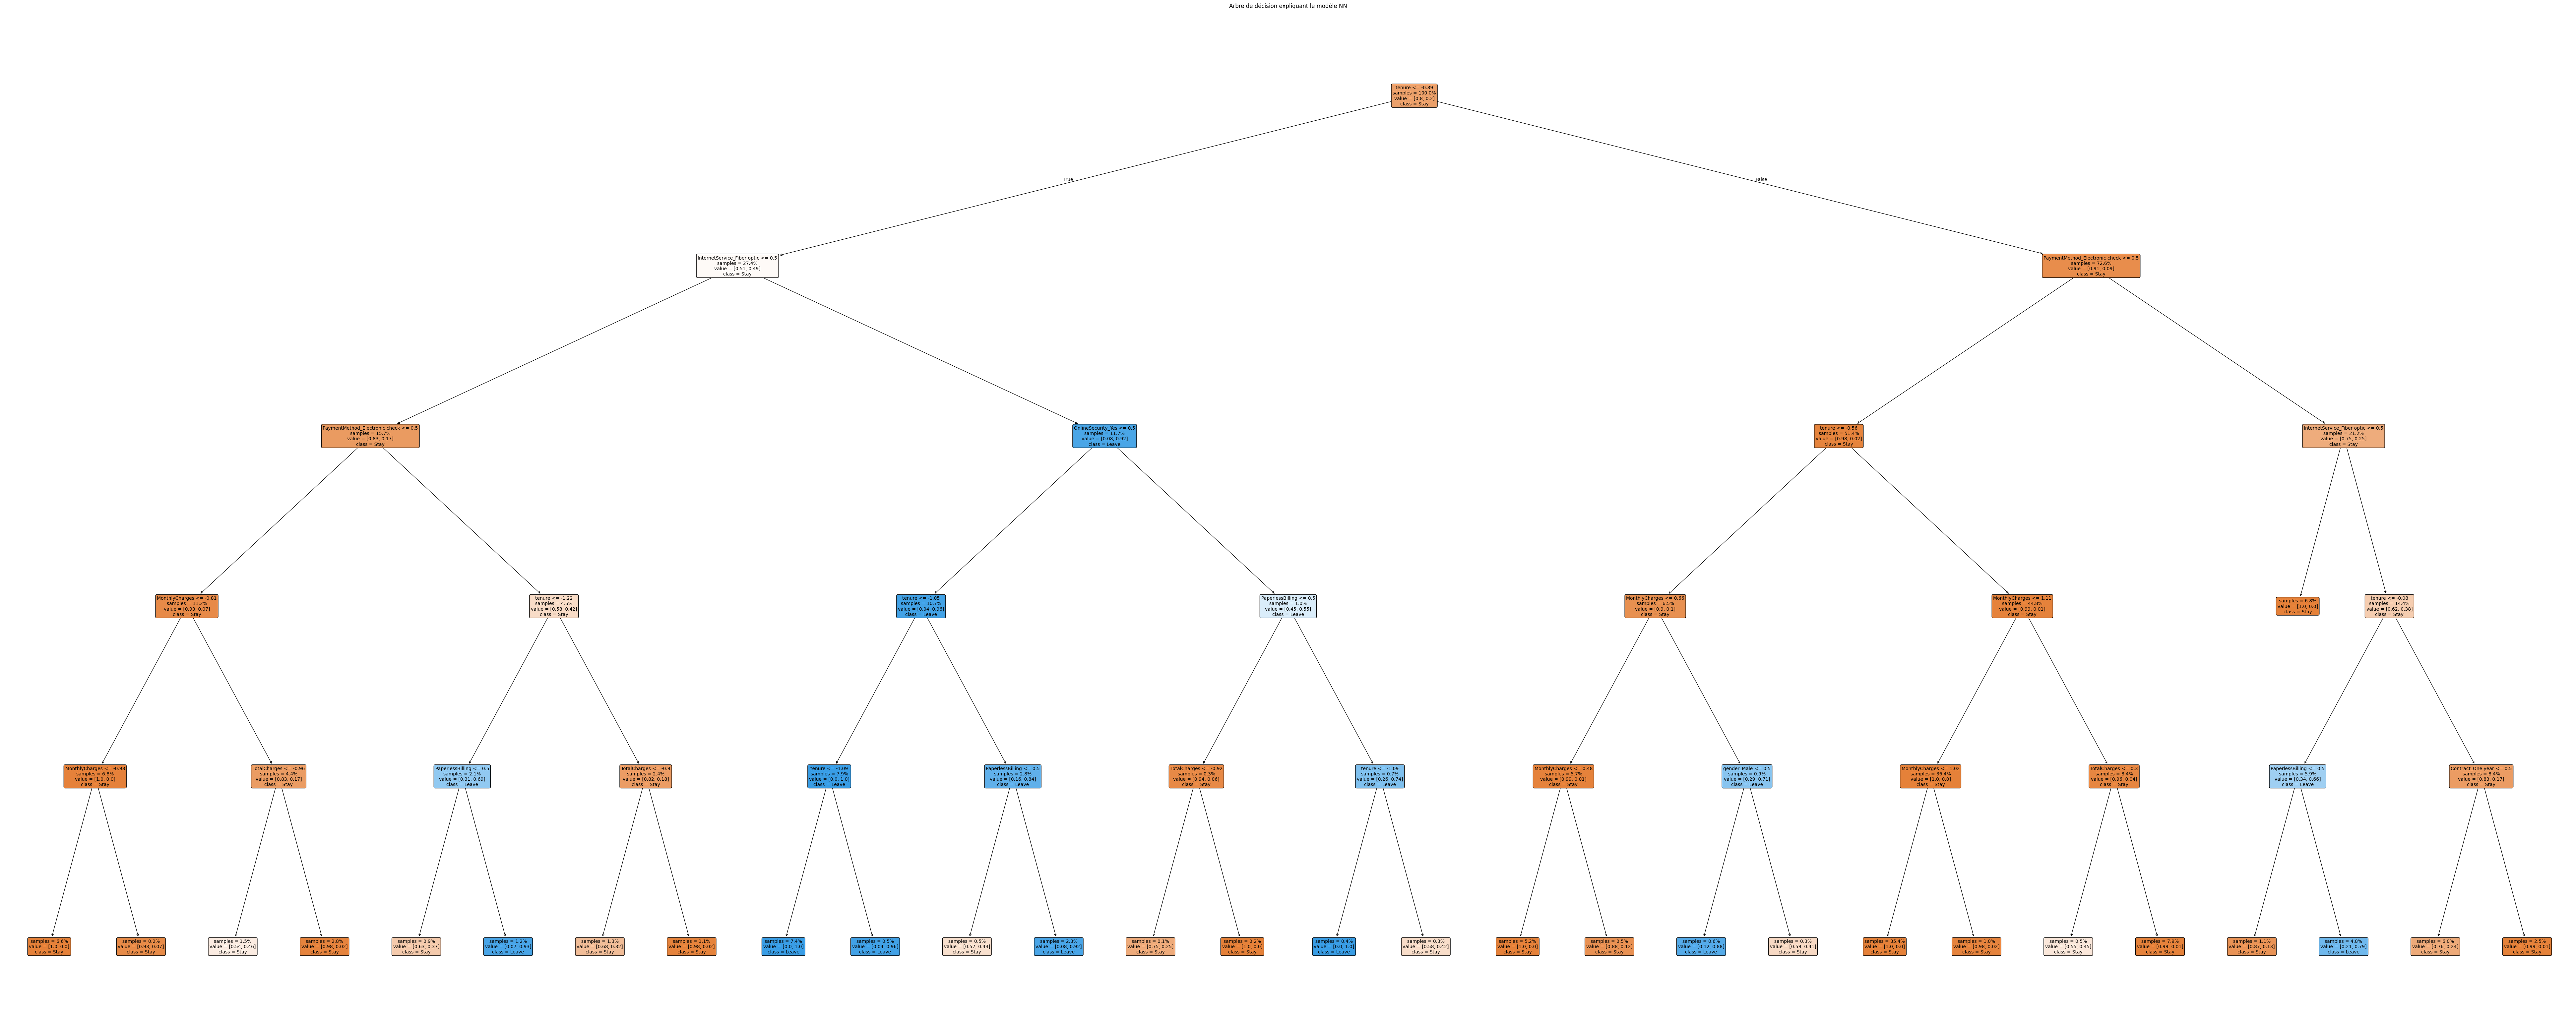

In [243]:
from sklearn.tree import plot_tree

plt.figure(figsize=(100, 40))
plot_tree(
    tree,
    feature_names=X_train.columns,
    class_names=['Stay', 'Leave'],
    filled=True,
    rounded=True,
    fontsize=10,           # Larger font for readability
    proportion=True,       # Show proportions at nodes
    impurity=False,        # Hide impurity for clarity
    precision=2            # Fewer decimals for thresholds
)
plt.title('Arbre de décision expliquant le modèle NN')
plt.show()

## Explicabilité post-hoc avec SHAP

Nous utilisons SHAP pour expliquer les prédictions de l'arbre de décision qui approxime le réseau de neurones (DT on NN predictions).
Cela permet d'obtenir des explications rapides et fiables grâce à TreeExplainer.

<Figure size 640x480 with 0 Axes>

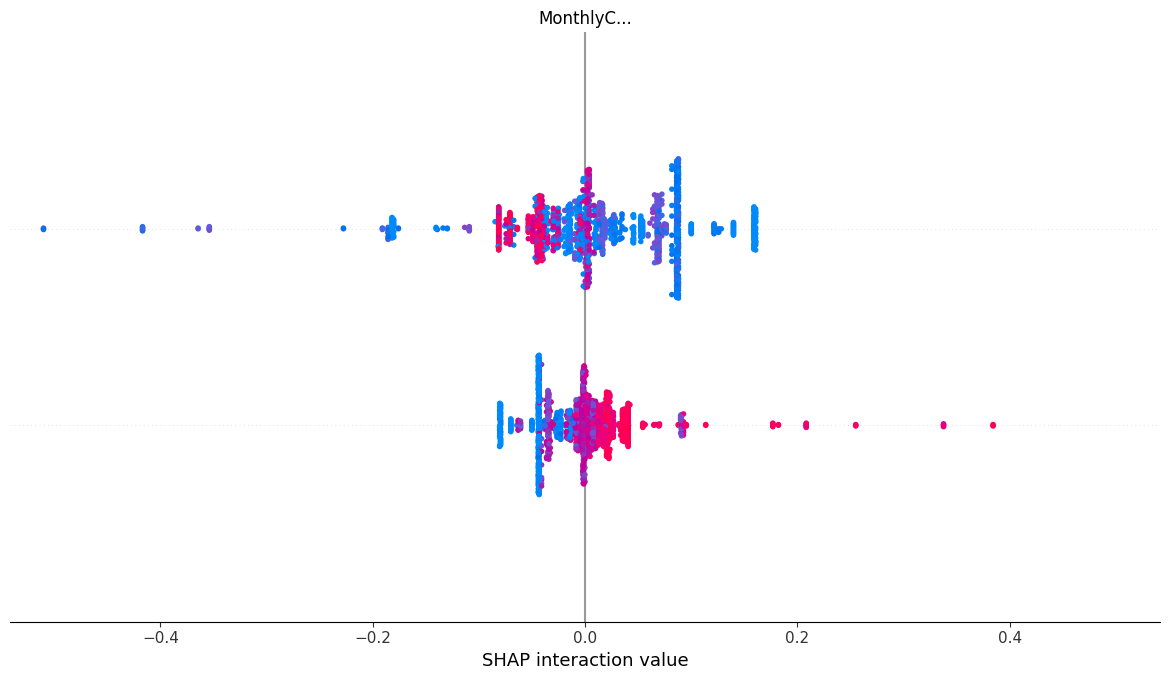

In [ ]:
import shap

# SHAP sur l'arbre de décision entraîné pour approximer le NN
explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_test)

# Beeswarm plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

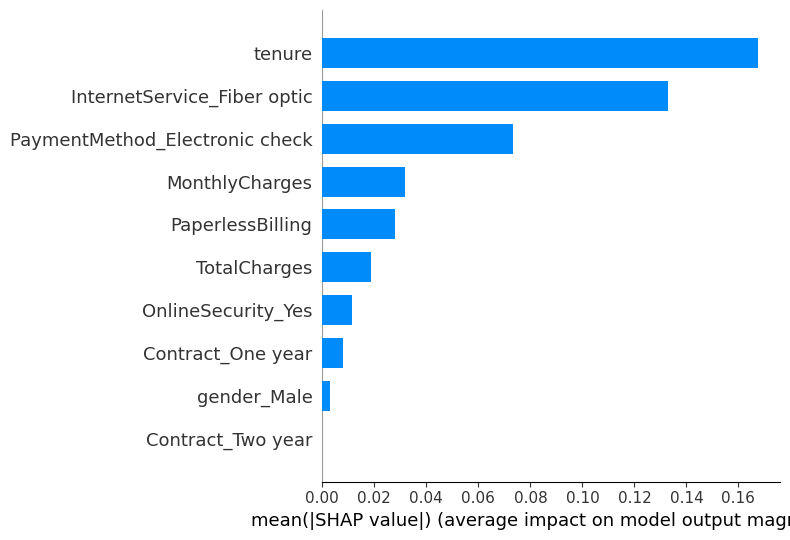

In [239]:
# Bar plot SHAP pour la classe positive (churn/Leave)
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X_test.columns, plot_type="bar")

## Explication locale avec LIME

Nous utilisons LIME pour expliquer la prédiction d'un individu du jeu de test.

In [240]:
from lime.lime_tabular import LimeTabularExplainer

# Fonction prédictive pour LIME
def lime_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        proba = model(X_tensor).squeeze().numpy()
        # LIME attend une matrice (n, 2) pour la proba de chaque classe
        return np.column_stack([1 - proba, proba])

explainer_lime = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Stay', 'Leave'],
    discretize_continuous=True,
    mode='classification'
)

# Choix d'un individu à expliquer
i = 42
exp = explainer_lime.explain_instance(X_test.values[i], lime_predict, num_features=10)
exp.show_in_notebook()

# Réponses aux questions du projet (Churn)

### 1. Quels types de clients sont les plus susceptibles de résilier leur contrat ?

Les clients les plus susceptibles de résilier ont une faible ancienneté (tenure courte), paient par prélèvement électronique (Electronic check), un contrat mensuel (peu d'engagement), des charges mensuelles élevées, n'ont pas ou peu de services additionnels (sécurité, backup, etc.), et utilisent la fibre optique (InternetService_Fiber optic).

### 2. Le prix est-il un facteur déterminant ou s'agit-il plutôt du manque de services ?

- Le prix (MonthlyCharges, TotalCharges) est un facteur important : les clients avec des factures élevées sont plus à risque.
- Mais le manque de services de sécurité/support (OnlineSecurity, TechSupport) et le type de contrat (mensuel vs annuel) sont aussi déterminants.
- L'analyse SHAP montre que ces facteurs sont tous importants, mais le prix et l'engagement ressortent en tête.

### 3. Quelles actions ciblées recommander (réductions, support technique, offres personnalisées) ?

- Proposer des réductions ciblées sur les charges mensuelles pour les clients à risque.
- Inciter à passer à un contrat plus long (engagement annuel ou bi-annuel).
- Offrir des services additionnels (sécurité, backup, support technique) gratuitement ou à tarif réduit.
- Mettre en place un support proactif pour les clients ayant contacté le service technique ou ayant peu de services.

### 4. Peut-on regrouper les clients à risque par profil pour des campagnes de rétention ?

Oui, il est possible de segmenter les clients à risque :
- Par exemple : 
  - Jeunes clients à forte facture et peu de services : proposer des packs de services.
  - Clients avec contrat mensuel : proposer une offre d'engagement avec avantage.
  - Clients fibre optique sans sécurité : cibler avec une offre sécurité.
- Ces groupes peuvent être identifiés à partir des variables importantes et utilisés pour des campagnes de rétention personnalisées.